<a href="https://colab.research.google.com/github/Nick7900/GLHMM_statistical_test_demo/blob/main/across_subjects_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Across-Subject Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)
This tutorial demonstrates how apply ```across-subject``` testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).
We will use data sourced from the Human Connectome Project (HCP) S1200 Young Adult dataset ([van Essen et al., 2013]((https://pubmed.ncbi.nlm.nih.gov/23684880/))).\

**NOTE: Running this tutorial requires the HCP data. Make sure you have been granted permission to use the HCP data. If not, apply for such permission to get the HCP data by following the instructions [here](https://db.humanconnectome.org/).**

 The HCP dataset provides an real-world context for this analysis and offers detailed information for each subject. ```Testing_across_subjects``` involves evaluating the relationship between one or more HMM-related aggregated statistics and behavioral traits, such as sex and age or individual traits.

We'll set up HMM-related aggregated statistics as the independent variable (```D```) and behavioral traits as the dependent variable (```R```). The goal is to assess the relationship between these variables.

Throughout the tutorial, we'll guide you on applying the [glhmm toolbox](https://github.com/vidaurre/glhmm) and drawing conclusions from the HCP dataset. While the setup of the glhmm toolbox may require some explanation, running the test itself is straightforward—simply input the variables ```D``` and ```R```, and define the specific ```method``` you wish to apply. In this case, the methods include permutation using regression or permutation using correlation and is described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time).



### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```


### Import libraries
Let's start by importing the required libraries and modules.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glhmm import glhmm, graphics, statistics, io, preproc

### Load data into Python enviornment <a id="prep_env"></a>
First, we need to load data files into our Python environment.
We will train a classic HMM on the ```data_measurement.npy``` from the HCP dataset that we exported in the previous notebook.

The file ```data_measurement.npy``` is a dataset of 4800 timepoints, 1001 subjects, and 50 parcellations.

Additionally, we will load the behaviroal measurements that accounts for both the  data_behavioral_HCP

In [ ]:
from pathlib import Path
# Get the current directory
PATH_PARENT = Path.cwd()
PATH_DATA = PATH_PARENT / "data_HCP"

# Load resting state fMRI data
D_data = np.load(PATH_DATA / "data_measurement_HCP.npy")
# Load behavioral data
R_data = np.load(PATH_DATA / "data_cognivtive_traits.npy") # Fluid intelligence
# Load behavioral data
confounds = np.load(PATH_DATA / "confounds_data.npy") # sex, age, rfMRI_motion

**Explore data**\
Let's take a closer look at the structure of the data.

In [ ]:
print(f"Shape of D_data: {D_data.shape}")
print(f"Shape of R_data: {R_data.shape}")
print(f"Shape of confounds: {confounds.shape}")

Shape of D_data: (4800, 1001, 50)
Shape of R_data: (1001, 15)
Shape of confounds: (1001, 3)


The dataset ```D_data``` has a shape of (4800, 1001, 50). In this context, 4800 represents the number of time points recorded, while 1001 indicates the number of subjects included. The final dimension, 50, corresponds to the number of Independent Component Analysis (ICA) components derived from the data.

In addition, we have ```R_data```, which has a shape of (1001, 15). This dataset also includes behvaioral measurements for each of the 1001 subjects, aligning with the number of subjects in ```D_data```. The 15 features represented in ```R_data``` are different cognitive traits for each subject.\
These cognitive traits are:\
* 'ReadEng_Unadj','PicVocab_Unadj','WM_Task_Acc','PMAT24_A_CR',\
* 'ListSort_Unadj','PMAT24_A_SI','PicSeq_Unadj','acVSPLOT_TC',\
* 'CardSort_Unadj','Language_Task_Acc','Flanker_Unadj','IWRD_TOT',\
* 'ProcSpeed_Unadj','PMAT24_A_RTCR','MMSE_Score'

```confounds``` has a shape of (1001, 3) and are confounding variables that will be regressed out from our analysis. The confounds are sex, age and rfMRI_motion (movement in the scanner)

### Data shape <a id="data_shape"></a>
When training a HMM the data should have the shape ```[(No. of subjects/sessions * No. of timepoints), No. of features]```, meaning that all subjects and/or sessions have been concatenated along the first dimension.
The second dimension is the number of features, e.g., the number of parcels or channels.


So we will go from having a dataset ```[4800, 1001, 50]``` of ```[No. of timepoints, No. of subject, No. of features]``` to a concatenated dataset ```[4804800, 50]``` that is based on ```[(No. of timepoints by No. of subject), No. of features]```

To get the concatenated data, we will use the function ```get_concatenate_subjects```

In [ ]:
# Concatenate the data
D_con= statistics.get_concatenate_subjects(D_data)

Look at the shape of the concatenated dataset

In [ ]:
D_con.shape

(4804800, 50)

For a quick sanity check, let's verify whether the concatenation was performed correctly on ```measurement_transpose```. We've essentially stacked up every timepoint from each subject sequentially.

To do this, we can compare a slice of our original design matrix, say ```measurement_transpose[:, 0, :]```, with the corresponding slice in the concatenated data, ```measurement_con[0:4800, :]```.

If the comparison ```D_trials[:, 0, :] == D_con[0:4800, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 4800 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [ ]:
D_data[:,0,:]==D_con[0:4800,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

We can also do that for the next subject to be sure

In [ ]:
D_data[:,1,:]==D_con[4800:9600,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Besides of having ```D_con```, we need to specify the indices in the concatenated timeseries corresponding to the beginning and end timepoints of each subjects with a shape of ```[No. of subjects, 2]```.\
In our case, it should be total of 4800 timepoints for each subject.

In [ ]:
#Generate indices of the timestamps for each subject in the data.
idx_subject = statistics.get_indices_timestamp(D_data.shape[0], D_data.shape[1])
# Visualize the output for the session indices
print(f"Indices for each session:\n {idx_subject}")

Indices for each session:
 [[      0    4800]
 [   4800    9600]
 [   9600   14400]
 ...
 [4790400 4795200]
 [4795200 4800000]
 [4800000 4804800]]


### Preprocessing data <a id="preprocess_data"></a>
Standardise timeseries for all following computations. This is an important step, especially when looking at differences between individuals, to make sure that analysis are not driven by measurement noise.


In [ ]:
# Preprocess the data
D_preproc,_ = preproc.preprocess_data(D_con,
                                      idx_subject,
                                      standardise = True)

Visualize the original and standardize time series

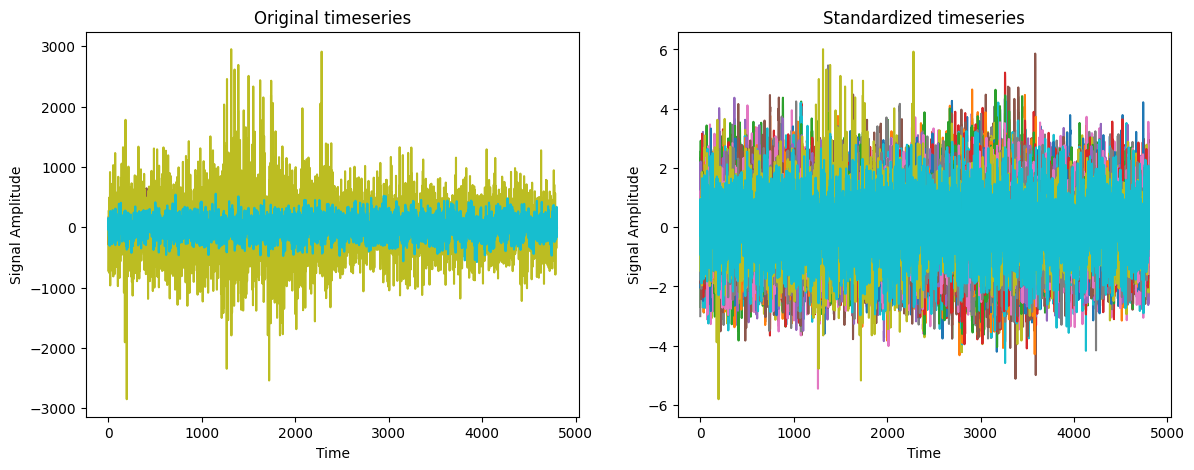

In [ ]:
# Create subplots
fig, ax = plt.subplots(1,2, figsize=(14, 5))

# Plot original timeseries
ax[0].plot(D_con[0:4800, :])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal Amplitude")
ax[0].set_title("Original timeseries")

# Plot standardized timeseries
ax[1].plot(D_preproc[0:4800, :])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Signal Amplitude")
ax[1].set_title("Standardized timeseries")

# Adjust layout
plt.subplots_adjust(hspace=0.5)

# Show plot
plt.show()


## Setup GLHMM
### Initialize and train a Hidden Markov Model (HMM) <a id="init_HMM"></a>
To begin, we initialize the glhmm object and set hyperparameters accordingly. In the case of the standard Gaussian HMM, we are not modeling an interaction between two sets of variables, so we set ```model_beta='no'```. The number of states is determined by the parameter ```K```, which we set to ```K=12``` in this tutorial. If you wish to model a different number of states, simply adjust ```K``` accordingly. In this scenario, we aim to represent states as Gaussian distributions characterized by a mean and full covariance matrix. Thus, each state is predetermined by both a mean amplitude and a functional connectivity pattern. To achieve this, specify ```covtype='full'```; note that the state-specific mean is automatically set by default.



In [ ]:
K = 12
hmm_HCP = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm_HCP.hyperparameters)

{'K': 12, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True

We then train the HMM using preprocessed measumrent data, ```D_preproc```, and indices for each subject,```idx_subject```. Since we here do not model an interaction between two sets of timeseries but run a standard HMM instead, we set ```X=None```. ```Y``` should be the timeseries in which we want to estimate states (```D_preproc```) and indices should be the beginning and end indices of each subject (```idx_subject```).


In [ ]:
# Train the HMM model
Gamma,Xi,FE = hmm_HCP.train(X=None, Y=D_preproc, indices=idx_subject)


The training process returns three key outputs. ```Gamma``` provides the state probabilities at each timepoint, which basically indicate the likelihood of being in various states throughout the observation period. This is useful for understanding the dominant states at different times.

```Xi``` represents the joint probabilities of being in particular states at two different timepoints. It helps to understand how transitions between states are likely to occur over time.

Finally, ```FE```  stands for the free energy of each iteration. It is a measurement of how well the model fits the data, with decreasing values indicating improved fit. Monitoring FE allows makes it possible to see if the model is effectively learning from the data across iterations.

### Data handling <a id="data_handle"></a>
Now we will take a step back and look at the data we are going to analyze

In [ ]:
print(f"Data dimension of Gamma: {Gamma.shape}")
print(f"Data dimension of behavioral measurements (R): {R_data.shape}")

Data dimension of Gamma: (4804800, 12)
Data dimension of behavioral measurements (R): (1001, 15)


Looking at ```Gamma``` =[4804800, 12], we find that gamma measurements are concatenated for every timepoint across subjects (4804800 in total, corresponding to 1001 subjects by 4800 timepoints). The dataset comprises 12 columns, each representing the 12 different states at each timepoint per subject. This bacicallay means that for each timepoint we got a probability value for being in a given state.

The behavioral measurements, denoted as ```R_data``` =[1001, 15], reveals that we have measurements for 1001 subjects, where there are 15 cognitive traits.



#### HMM-aggregated statistics <a id="HMM-agg"></a>
The ```test_across_subjects``` function performs permutation tests between subjects. The ```Gamma``` dataset is a concatenated collection of 4804800 data points, combining 1001 subjects with 4800 time points each, and includes 12 columns representing different states at each time point.

To carry out the permutation tests, we first compute aggregated statistics related to the HMM. This involves deriving summary values for each subject from their entire time series. Specifically, we calculate Fractional Occupancy (FO) using the ```get_FO``` function from the ```utils``` module, which provides the probability distribution for each state across the time series. This results in a single set of values per subject, summarizing state probabilities into a distribution that sums to one.


We will then end up with our predictor matrix ```D``` will have dimensions 1001 by 12, where 1001 represents the number of subjects and 12 represents the number of states.


In [ ]:
# Calculate FO
FO = glhmm.utils.get_FO(Gamma, idx_subject)

Let's take a closer look at the structure of ```FO```.

In [ ]:
print(f"Data dimension of FO: {FO.shape}")

Data dimension of FO: (1001, 12)


In this example, (```FO```) is a 1001x12 matrix and represent the distribution of the duration spent in different states across 1001 subjects. Each row of the matrix corresponds to a subject, and each column represents a specific state.

For instance, if the FO matrix entry ```FO[i, j]``` is 0.2, it suggests that, on average, subject ```i``` spends 20% of the time in state ```j```. These fractional occupancies offer insights into the temporal dynamics of the underlying states of the system across a population of subjects. It makes it possible to understand the patterns of behavior and transitions between states.

Now, both ```FO``` and ```R_data``` share the same number of observations, which correspond to the total number of subjects. As mentioned in the paper, the testing procedure involves a (N-by-p) design matrix, denoted as D, where p signifies the number of predictors. In our case, ```FO``` serves as the independent variable ```D```.
Additionally, we have a matrix ```R_data``` of the behavioral measurements with dimensions (N-by-q), representing dependent variables.

Now we can plot FO for all subjects to see the gamma distribution

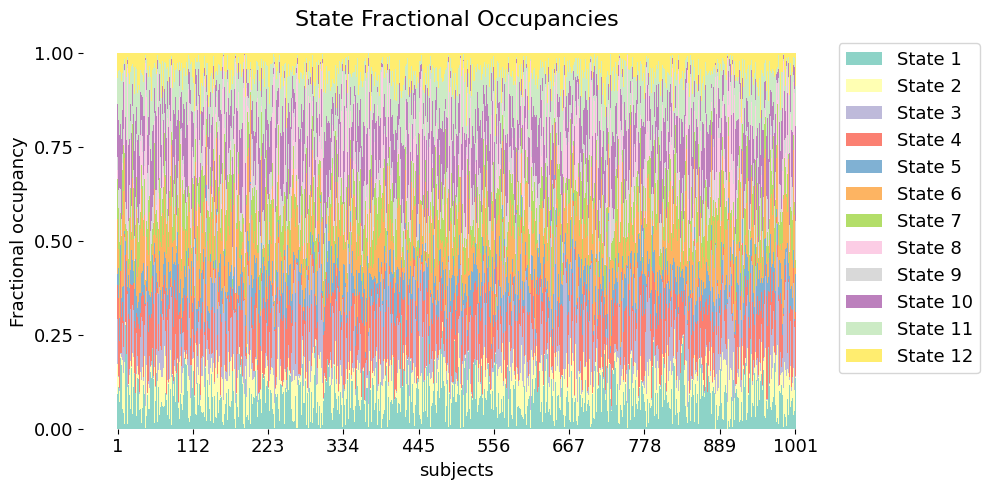

In [ ]:
graphics.plot_FO(FO,num_ticks=10, xlabel="subjects", width=1, figsize=(10,5))

## Across-subjects testing <a id="across_subjects"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_subjects``` function to study the relationships between the ```FO``` (D) and the corresponding ```behavioral variables``` (R) using permutation testing.

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis—there is no difference or relationship between variables of interest to be tested. For the ```across_subject``` test it implies that each observation represents an individual subject, so we can shuffle or rearrange across subjects, as depicted in Figure 5A in the [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).


![image-2.png](attachment:image-2.png)

 **Figure 5A**: A 9 x 4 matrix representing permutation testing across subjects. Each row corresponds to a subject, with one observation each. The first column: displays the original index of each subject (perm=0). Next columns: examples of permuted subject indices.



### Family structure <a id="fam-struc"></a>
By default, the ```test_across_subjects``` function assumes exchangeability across all subjects, meaning any pair of subjects can be swapped. However, in reality, familial connections between subjects may exist and can therefore violate the assumption that each subject are independent from each other.

To accommodate these connections, permutation tests with HCP data—or any dataset—involve creating the ```EB.csv``` file (Exchangeability Block). This file organizes data into blocks, each representing a family and makes it possibole to perform collective shuffling of entire families. For a more detailed explanation, refer to ([Winkler et al, 2015](https://www.sciencedirect.com/science/article/pii/S105381191500508X?via%3Dihub)). A tutorial on creating your ```EB.csv``` from the HCP dataset can be found in the notebook [HCP_multi_level_block_permutation.ipynb](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/multi_level_block_permutation_tutorial.ipynb)

When using the ```test_across_subjects``` function to consider family structure, you input a dictionary and we call it ```dict_fam```. This dictionary specifies the directory to load the ```EB.csv``` file and includes optional parameters for running the permutation. In our example, we'll use default options and define the file location of the family structure data (```EB.csv```).

In [ ]:
dict_fam = {
    'file_location': 'EB.csv',  # Specify the file location of the family structure data
    # 'file_location': r'C:\Users\...\EB.csv'
}

### Across subjects - multivariate <a id="perm-multivariate"></a>
In multivariate analysis, we are trying to explain the relationships between predictor variables (```D```) the response variable or signal (```R```).

**Understanding multivariate:**\
The goal is to identify which factors affect our behavioral measurements, such as how the brain activity is related to different measurements for fluid intelligence.
We examine how much of the variation in these measurements can be explained by brain activity, specifically how the ```FO```, which represents the distribution of time spent in different states, relates to these features. We use $R^2$ to evaluate this relationship.

When we find a significant result, it suggests that changes in ```FO``` are important for explaining the variability in behavioral measurements.


**Run the ```test_across_subjects``` function**:\
To run the ```test_across_subjects``` function requires providing inputs of ```FO``` (```D```) and ```data_behavioral``` (```R```). Sense we take family structure into account we will also include the variable ```dict_fam``` as an input.  Additionally, confounding variables will be regressed out when doing permutation testing.
To initiate multivariate-based permutation testing, set ```method="multivariate"```. Additionaly, we set ```test_statistics_option="True"``` to export the permuation distribution of the statistical test

In [ ]:
# Set the parameters for between-subject testing
method = "multivariate"
Nperm = 10_000 # Number of permutations (default = 0)
test_statistic_options = True
# Perform across-subject testing
result_regression  =statistics.test_across_subjects(FO, R_data, confounds=confounds, method=method,Nperm=Nperm,
                                                    dict_family=dict_fam, test_statistics_option=True)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [01:15<00:00, 133.31it/s]


We can now examine the local ```result_regression``` variable.

In [ ]:
result_regression

{'pval': array([3.29967003e-03, 2.28977102e-02, 9.99900010e-05, 2.77772223e-01,
        1.09989001e-03, 5.18248175e-01, 3.59964004e-02, 4.62253775e-01,
        1.75682432e-01, 9.99900010e-05, 1.66483352e-01, 2.91770823e-01,
        9.68903110e-02, 7.29527047e-01, 2.28277172e-01]),
 'base_statistics': array([0.03043899, 0.02424909, 0.03522202, 0.01359675, 0.03120157,
        0.0103549 , 0.02316683, 0.01223258, 0.0157031 , 0.03913199,
        0.01604408, 0.01356481, 0.01808038, 0.00817593, 0.01421785]),
 'test_statistics': array([[0.03043899, 0.02424909, 0.03522202, ..., 0.01808038, 0.00817593,
         0.01421785],
        [0.0207045 , 0.01813539, 0.01987777, ..., 0.00973605, 0.00733318,
         0.01471716],
        [0.00882071, 0.0102151 , 0.01029015, ..., 0.01531066, 0.01024212,
         0.01261921],
        ...,
        [0.00835346, 0.00880924, 0.01697847, ..., 0.00707429, 0.0082274 ,
         0.00738322],
        [0.01347332, 0.0202474 , 0.0124576 , ..., 0.01855316, 0.01112028,
   

What we can see here is that ```result_regression``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```.

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [paper](https://www.biorxiv.org/content/10.1101/2023.01.03.522583v4).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nperm```: Is the number of permutations that has been performed.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

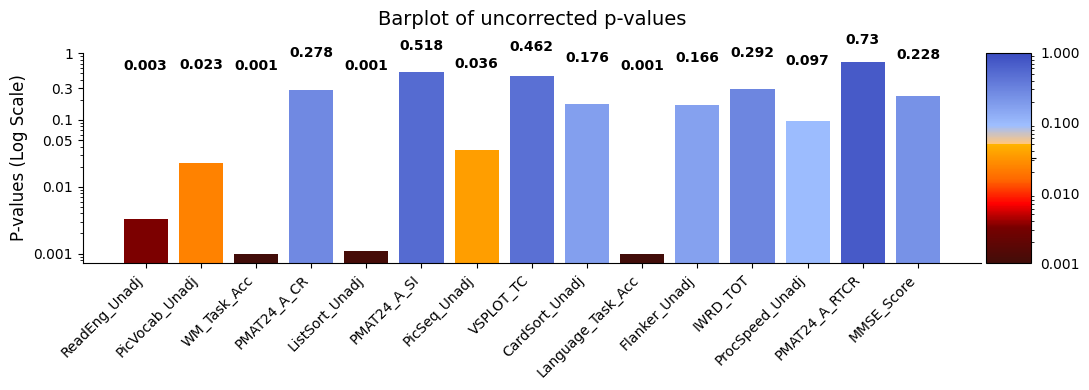

In [ ]:
# Plot p-values
xticklabels = ['ReadEng_Unadj','PicVocab_Unadj','WM_Task_Acc','PMAT24_A_CR',
                 'ListSort_Unadj','PMAT24_A_SI','PicSeq_Unadj','VSPLOT_TC','CardSort_Unadj',
                 'Language_Task_Acc','Flanker_Unadj','IWRD_TOT','ProcSpeed_Unadj','PMAT24_A_RTCR','MMSE_Score']
graphics.plot_p_values_bar(result_regression["pval"], title_text ="Barplot of uncorrected p-values",
                      figsize=(11, 4), alpha=0.05, xticklabels=xticklabels)

**Multiple Comparison**\
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

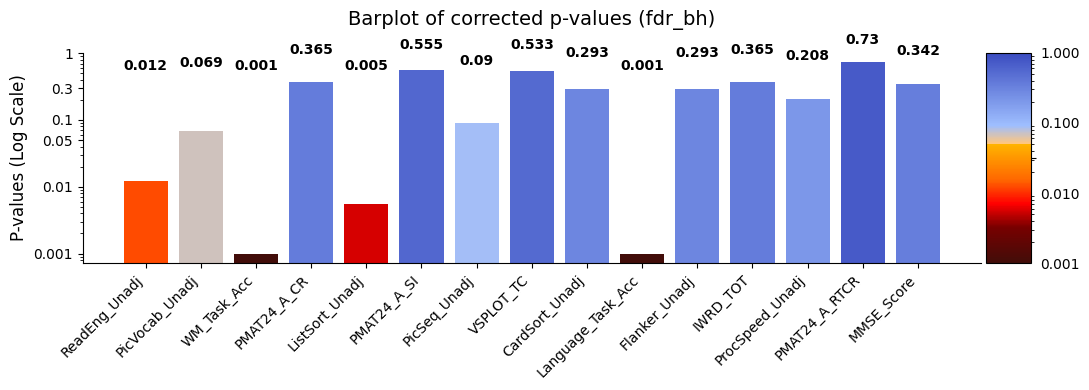

In [ ]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_regression["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected, title_text ="Barplot of corrected p-values (fdr_bh)",
                      figsize=(11, 4), alpha=0.05, xticklabels=xticklabels)

Now we will try to correct it using FWER maxT

In [ ]:
# Set the parameters for between-subject testing
method = "multivariate"
Nperm = 10_000 # Number of permutations (default = 0)
test_statistic_options = True
FWER = True
# Perform across-subject testing
result_regression_FWER  =statistics.test_across_subjects(FO, R_data, confounds=confounds, method=method,Nperm=Nperm,
                                                    dict_family=dict_fam, test_statistics_option=True, FWER_correction=FWER)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [01:17<00:00, 128.21it/s]


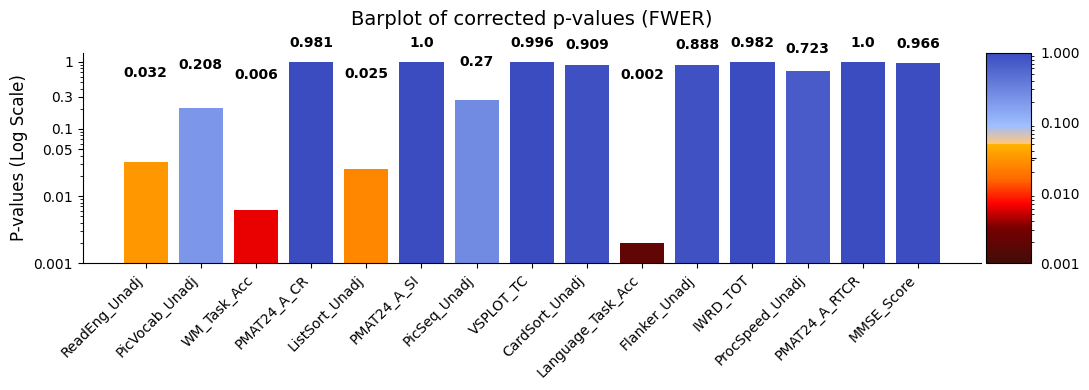

In [ ]:
graphics.plot_p_values_bar(result_regression_FWER["pval"], title_text ="Barplot of corrected p-values (FWER)",
                      figsize=(11, 4), alpha=0.05, xticklabels=xticklabels)


### Across subjects - Correlation <a id="perm-correlation"></a>
In univariate analysis, we aim to understand the relationship between one predictor variable (```D```) and one response variable (```R```) at the time, rather than looking at multiple factors at once.\
The goal is to identify how brain activity is related to specific behavioral measurements, such as fluid intelligence. We focus on how much variation in these measurements can be explained by brain states, particularly using the ```FO```, which represents the distribution of time spent in different brain states. This tests uses the correlation coefficients to measure the strength of the relationship between brain activity and the behavioral features.

When we find a significant result, it means that the changes in ```FO``` are strongly linked to the variations in these behavioral measurements.

**Run the ```across_subjects``` function**:\
To run the test_across_subjects function, you need to provide the ```FO``` data (D) and the behavioral data (R). Since we account for family relationships in the analysis, you’ll also need to include the family structure variable.  Additionally, we can account for confounding variables by regressing them out through permutation testing.\
To perform univariate permutation testing, set the method to ```method="univariate"```. Additionally, you can set ```test_statistics_option="True"``` to export the distribution of the statistical test from the permutation analysis.



In [ ]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 10_000 # Number of permutations (default = 0)
test_statistic_option=True
# Perform across-subject testing
result_univariate  =statistics.test_across_subjects(FO, R_data, confounds=confounds, method=method,Nperm=Nperm,
                                                dict_family=dict_fam,
                                                test_statistics_option=test_statistic_option)


Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [07:24<00:00, 22.49it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value and correlation matrix.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

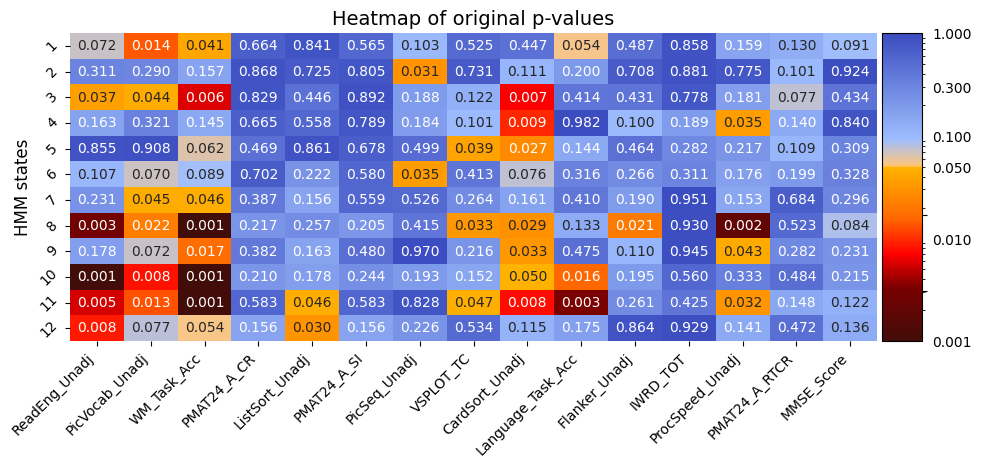

In [ ]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_p_value_matrix(result_univariate["pval"], title_text ="Heatmap of original p-values",
                      figsize=(11, 4), ylabel="HMM states", alpha=alpha,
                      xticklabels=xticklabels, xlabel_rotation=45,normalize_vals=True, annot=True)

**Visualization correlation coefficients (base statistics)**\
Now we can look at the correlation coefficients between the HMM states and the corresponding behavioral parameters "sex" and "age".

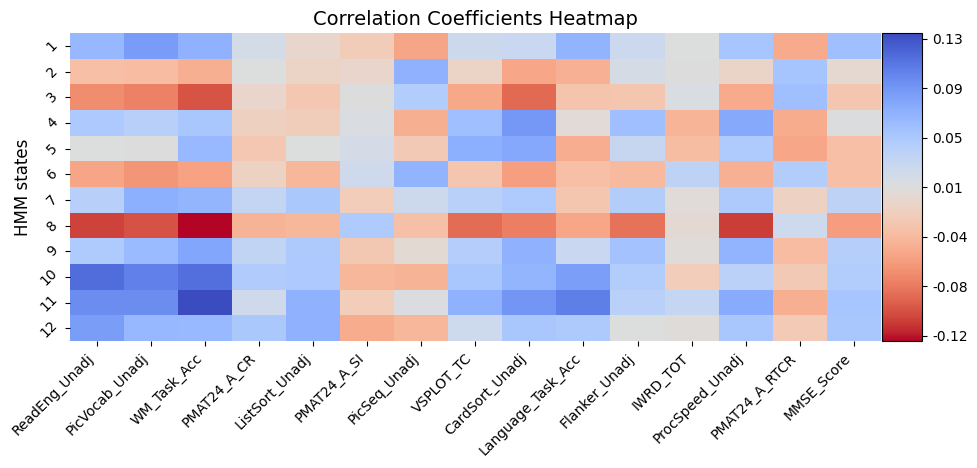

In [ ]:
from importlib import reload
reload(graphics)
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_correlation_matrix(result_univariate["base_statistics"], result_univariate["statistical_measures"],
                      figsize=(11, 4), ylabel="HMM states",
                      xticklabels=xticklabels, xlabel_rotation=45)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

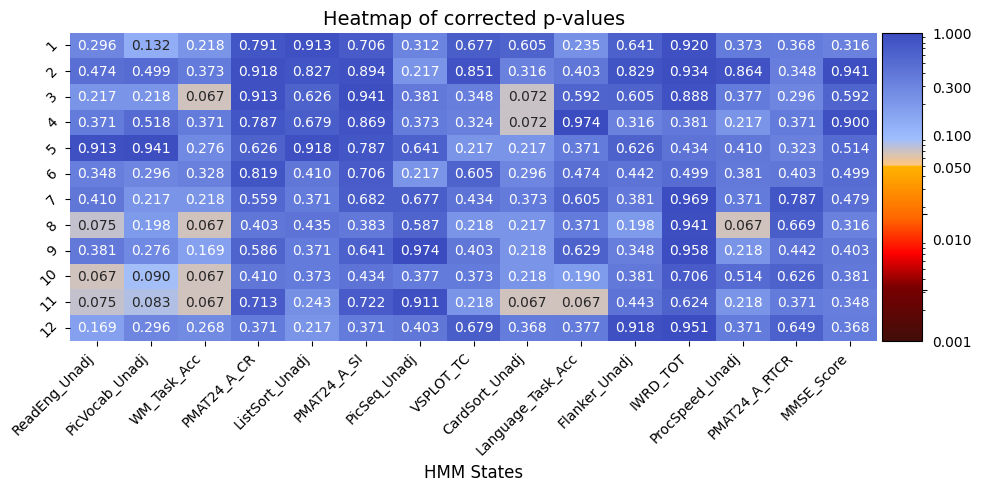

In [ ]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(11, 4), xlabel="HMM States",
                             ylabel="", xticklabels=xticklabels, xlabel_rotation=45, annot=True)

After applying Benjamini/Hochberg for multiple comparisons, none of the p-values remain significant, suggesting a high likelihood of a false negative.

In [ ]:
# Set the parameters for between-subject testing
method = "univariate"
Nperm = 10_000 # Number of permutations (default = 0)
FWER = True
# Perform across-subject testing
result_univariate_FWER  =statistics.test_across_subjects(FO, R_data, confounds=confounds, method=method,Nperm=Nperm,
                                                dict_family=dict_fam,
                                                test_statistics_option=test_statistic_option,FWER_correction=FWER)


Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [07:28<00:00, 22.29it/s]


Plot FWER corrected p-values

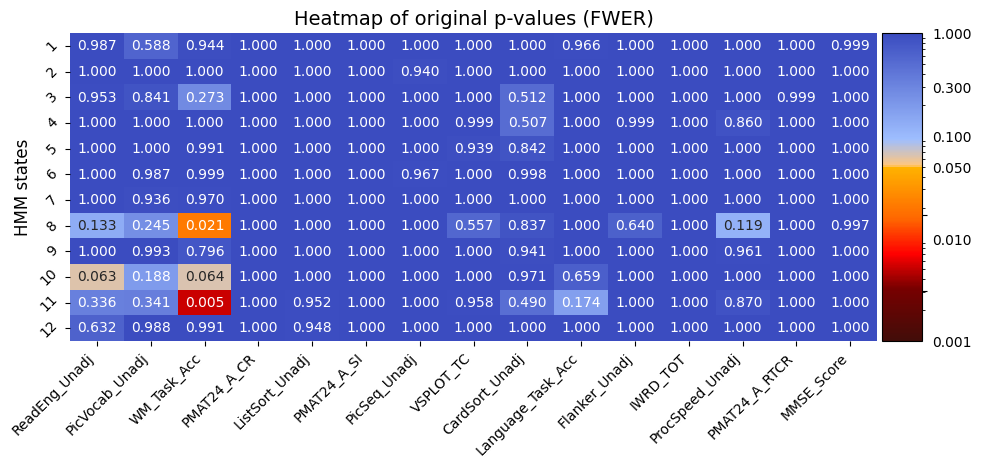

In [ ]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_p_value_matrix(result_univariate_FWER["pval"], title_text ="Heatmap of original p-values (FWER)",
                      figsize=(11, 4), ylabel="HMM states", alpha=alpha,
                      xticklabels=xticklabels, xlabel_rotation=45,normalize_vals=True, annot=True)

**Plot permutation distribution**\
Presented here are the significant test statistics of our permutation distributionfor the different states.
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

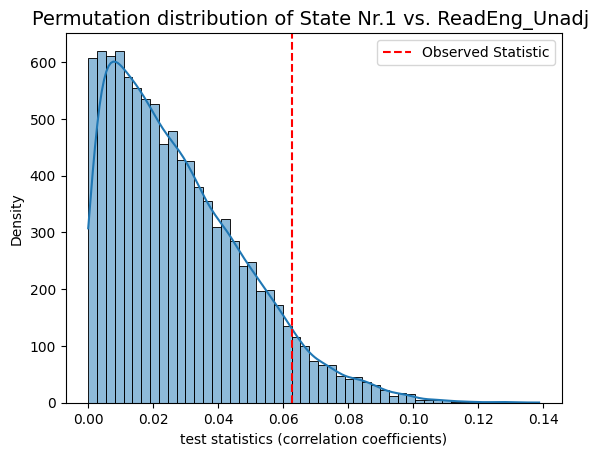

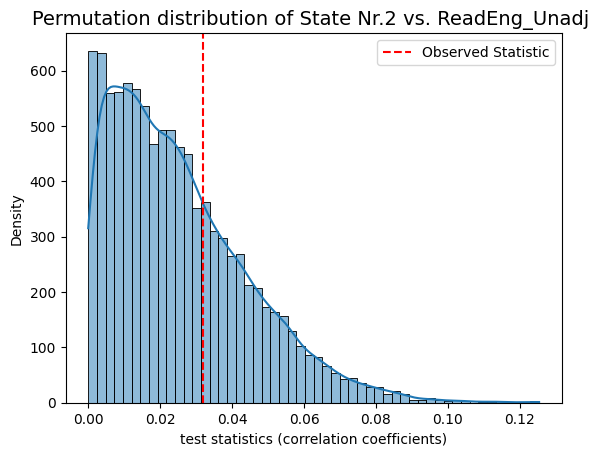

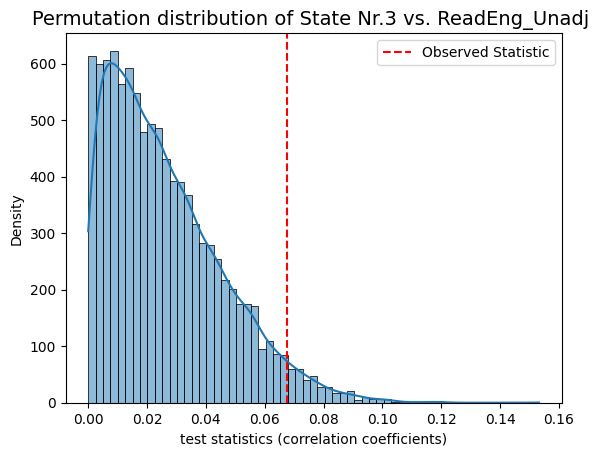

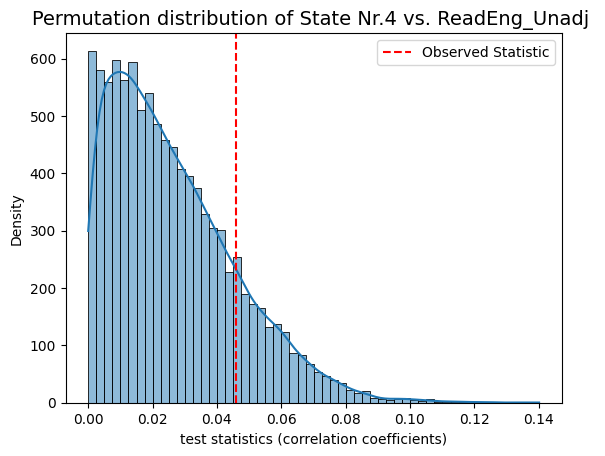

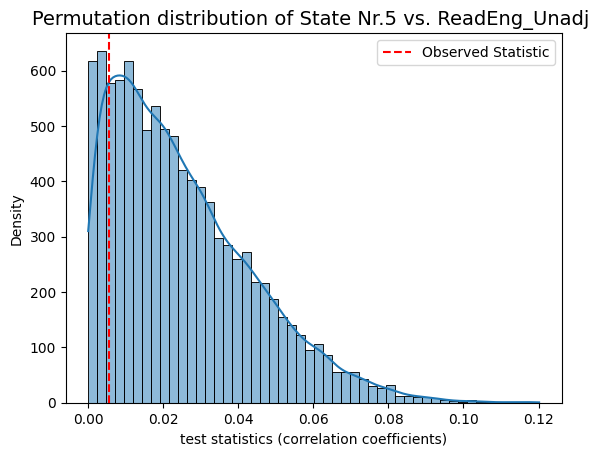

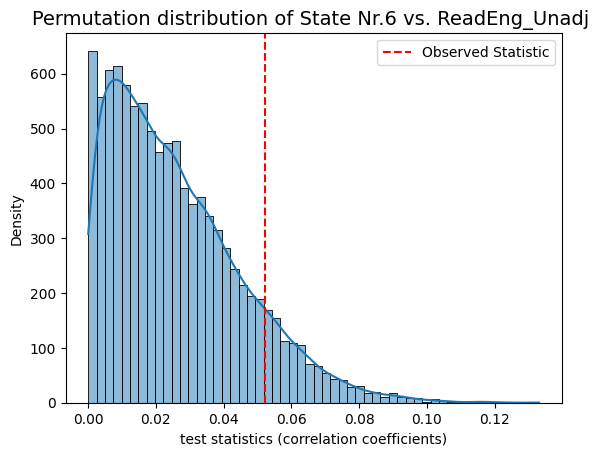

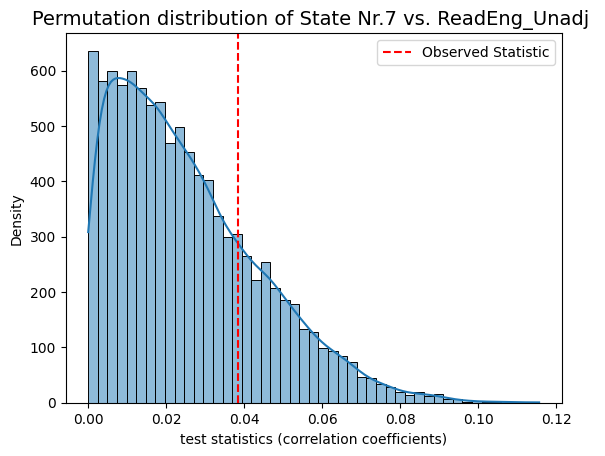

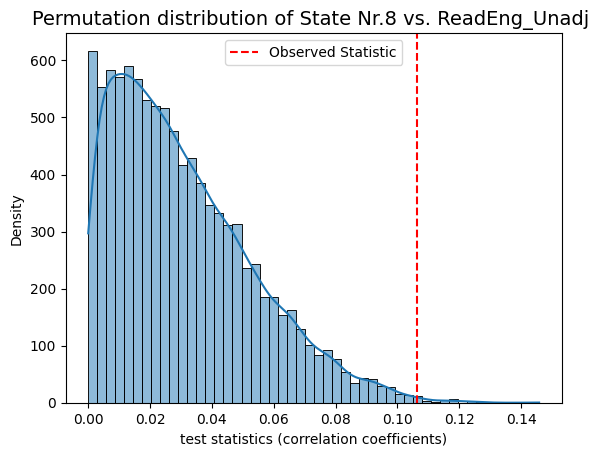

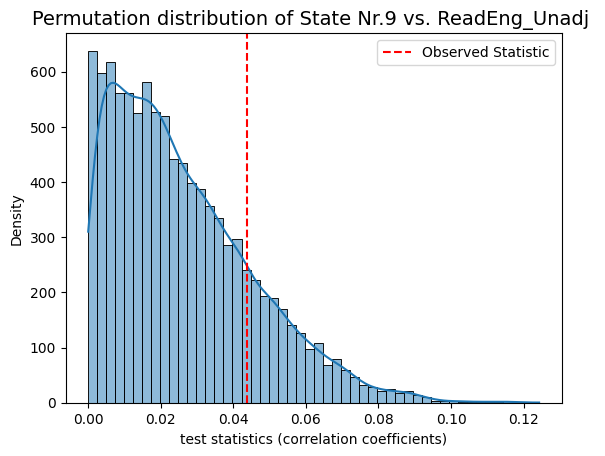

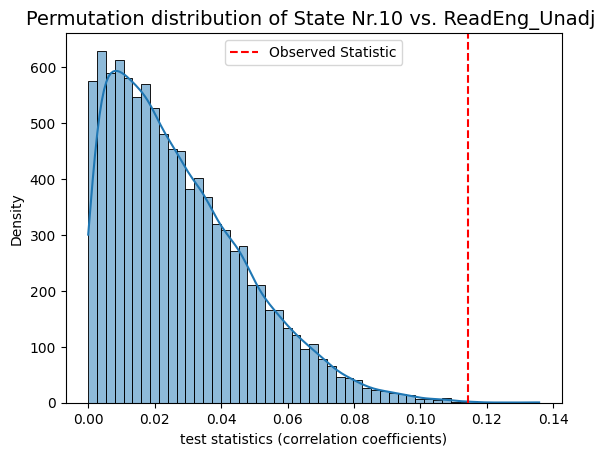

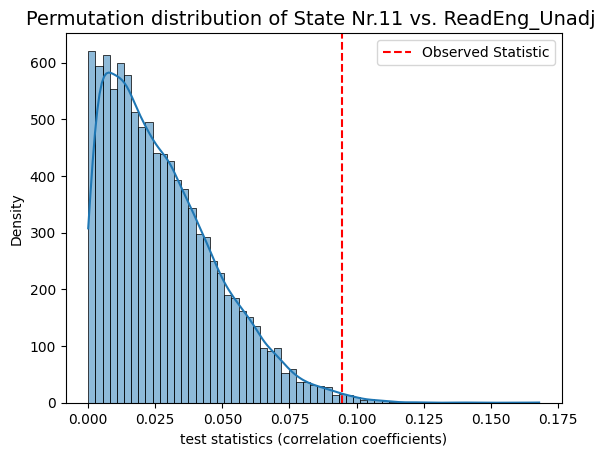

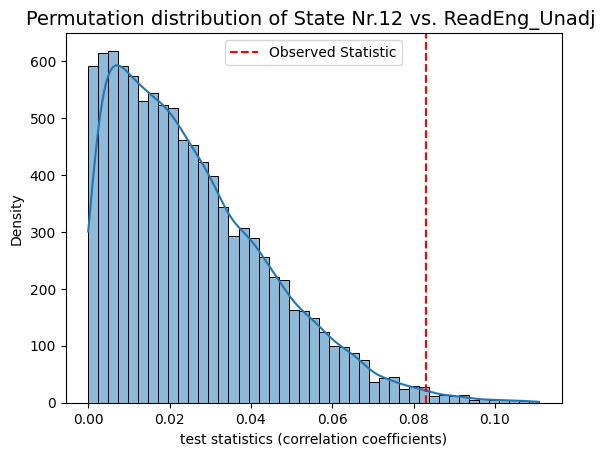

In [ ]:
# Plot test statistics for pvals
column_pos =0 # Sex is in column position 0
xlabel = "test statistics (correlation coefficients)"
#significant_timestamp_position = np.where(pval_corrected< alpha)

# Visualizing the permutation distribution for sex, which got index=0
for i in range(result_univariate["test_statistics"].shape[1]):
    graphics.plot_permutation_distribution(result_univariate["test_statistics"][:,i,column_pos],title_text=f"Permutation distribution of State Nr.{i+1} vs. ReadEng_Unadj ", xlabel=xlabel )